In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob
import re

import cv2
import geopandas as gpd
import pandas as pd

import albumentations as A

import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import model
import metrics
import config
import utis
import train_val_test

from matplotlib import pyplot as plt, cm

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
FILTER_PATH = '../data/geopackages/patch_keys.gpkg'

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

### Weights and Biases

In [3]:
!wandb login 

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Custom Split Dataset

In [4]:
# Read file 
geo_df = gpd.read_file(FILTER_PATH) # contains the idxs with a selection of non-noisy and noisy data

# Define the filters 
filters = {'non_veg_idxs' : geo_df.query("status == 0")['index'],
       'veg_idxs' :  geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'single_trees_idx' : geo_df.query("status == 3")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index'], 
       'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]}

# fix bug of the test_size
data_portion = 'fine_labels' # ['coarse_plus_fine_labels', 'fine_labels', 'coarse_labels']
rate = 1.
X_train, y_train, X_val, y_val, X_test, y_test = utis.custom_split(filters, test_size=40, image_paths=image_paths, mask_paths=mask_paths,  data_portion=data_portion, rate_of_coarse_labels=rate)

# # retrieve the ids of the X_test dataset for later
# file_idxs = [utis.get_file_index(ids) for ids in X_test]

### Dataloader

In [5]:
# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.9),
      A.VerticalFlip(p=0.9), 
      A.Transpose(p=0.9),
      A.CLAHE(p=1),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform, split_type=None)
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform, split_type=None)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')

data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  296
Validation set size:  75
Testing set size:  40


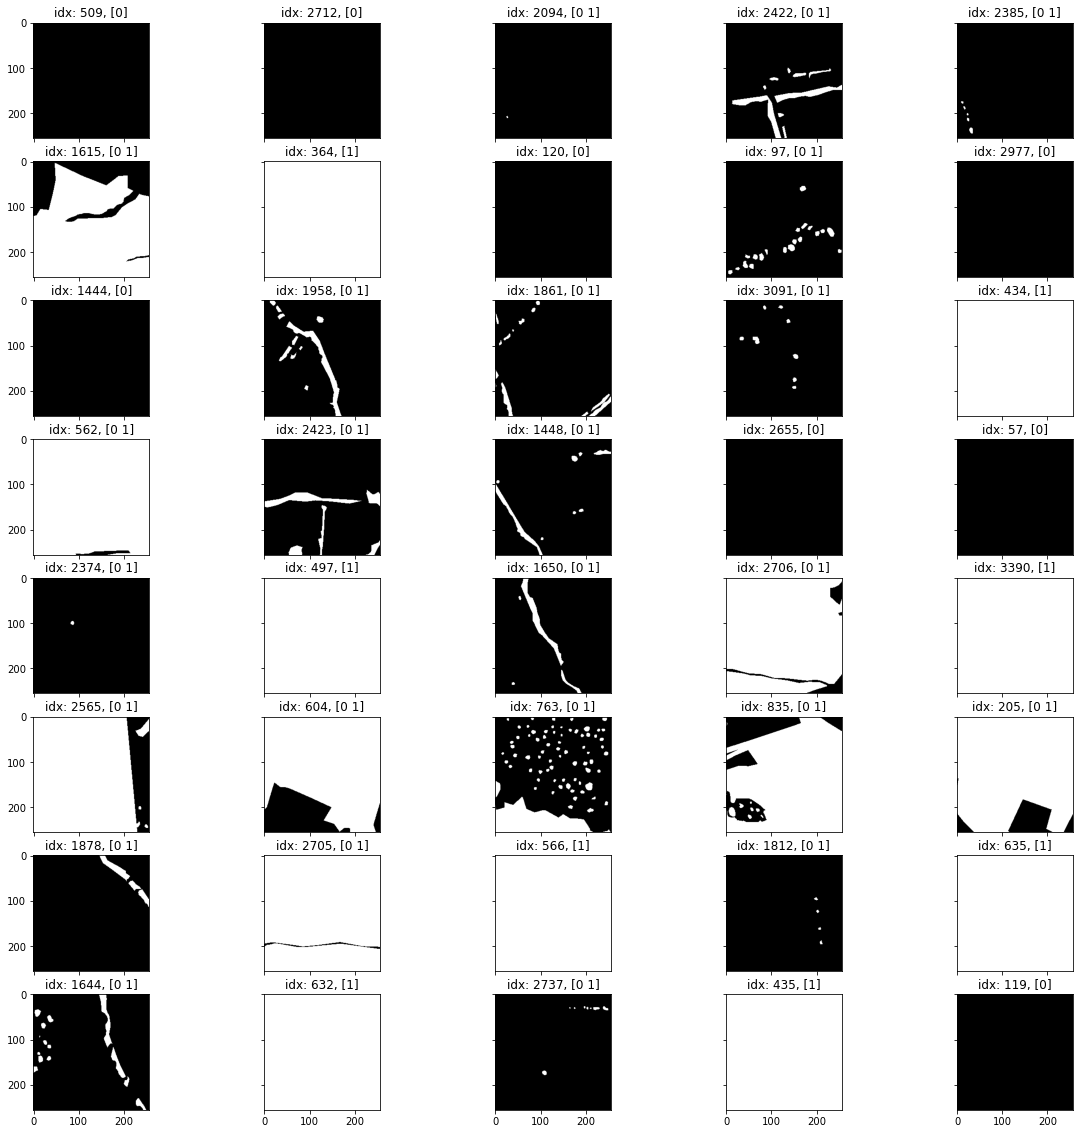

In [6]:
# Plot
n_col = 5
n_row = int(len(y_test)/n_col)

_, axs = plt.subplots(n_row, n_col, figsize=(20,20), sharex=True, sharey=True)
axs = axs.flatten()
cmap = cm.get_cmap('gray')
random.Random(4).shuffle(y_test)
random.Random(4).shuffle(X_test)

for i, ax in zip(y_test, axs):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap=cmap, vmin=0)
    ax.set_title(f'idx: {utis.get_file_index(i)}, {np.unique(img)}')
plt.show()

### Check if CUDA is available

In [7]:
config.DEVICE

'cuda'

### Training and Validating

In [8]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    dice = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward with autocast        
        with autocast():
            pred = model(x)
            loss = lossFunc(pred, y)
            
        optim.zero_grad()  # zero out any previously accumulated gradients    
        scaler.scale(loss).backward() # study this 
        scaler.step(optim)
        scaler.update()
        
#         # perform a forward pass and calculate the training loss
#         pred = model(x)
#         loss = lossFunc(pred, y)
        
#         opt.zero_grad()  # zero out any previously accumulated gradients
#         loss.backward() # obtain the gradients with respect to the loss
#         opt.step() # perform one step of gradient descendent
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        dice += all_metrics['dice_coeff']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'], dice = all_metrics['dice_coeff'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    avgDice = dice / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    training_history["IoU"].append(avgIOU) # save the acc 
    
    # WANDB
    # wandb.log({
    # # "Examples": example_images,
    # "Train Loss": avgTrainLoss,
    # "Train Accuracy": avgAccLoss,
    # "IoU_train":avgIOU})
    
    return training_history

In [9]:
def validation(model, dataloader, lossFunc, epoch):
    
    # set the model in evaluation mode
    model.eval()
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    # switch off autograd
    example_pred = []
    example_gt = []
    
    with torch.no_grad():
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        
        for batch_idx, (x_val, y_val) in enumerate(loop):
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']

            # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            # example_pred.append(wandb.Image(pred_val[0], caption=f"pred_iter_n_{batch_idx}"))
            # example_gt.append(wandb.Image(y_val[0].float(), caption=f"gt_iter_n_{batch_idx}"))
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])
                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the acc
    
    # WANDB
    # wandb.log({
    # "Predictions": example_pred,
    # "GT": example_gt,
    # "Val Accuracy": avgAccLoss,
    # "Val Loss": avgValLoss,
    # "IoU_val": avgIOU})
    
    return validation_history

### MAIN

In [10]:
# WandB – Initialize a new run
# wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

opt = optim.Adam(unet.parameters(), lr=config.LR)
# opt = optim.SGD(unet.parameters(), lr=config.LR, momentum=0.95, weight_decay=0.01)
scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=10, verbose=True)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
# wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    # scheduler.step(validated['IoU_val'][-1])
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e, data_portion, rate_of_coarse_labels=rate)
        best_accuracy = validation_history['IoU_val'][-1]

Training the network for 100 epochs, with a batch size of 16


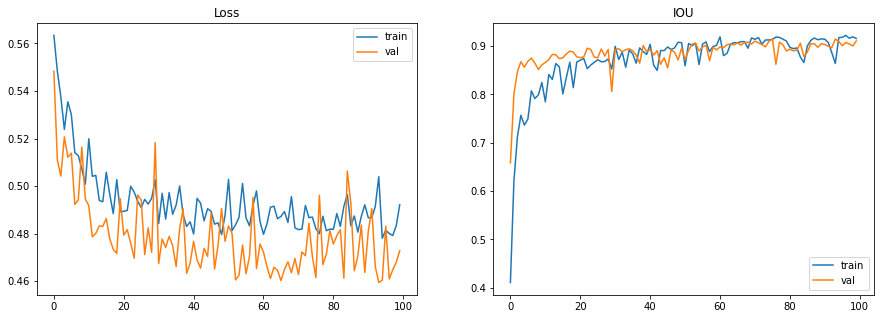

In [11]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(training_history['IoU'], label= 'train')
ax[1].plot(validation_history['IoU_val'], label='val')
ax[1].set_title('IOU')
ax[1].legend()
plt.show()

### Predictions

../best_model/fine_labels_best_model_epoch_76_iou_0.915_acc_0.97.pth


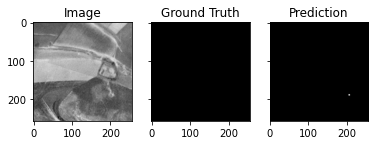

<Figure size 432x288 with 0 Axes>

Saving patch_0_id_509.png


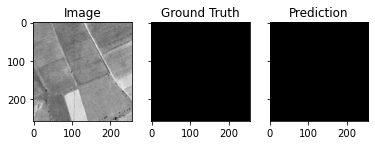

<Figure size 432x288 with 0 Axes>

Saving patch_1_id_2712.png


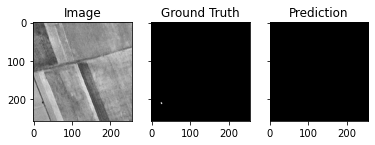

<Figure size 432x288 with 0 Axes>

Saving patch_2_id_2094.png


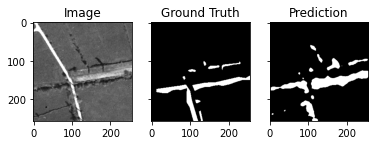

<Figure size 432x288 with 0 Axes>

Saving patch_3_id_2422.png


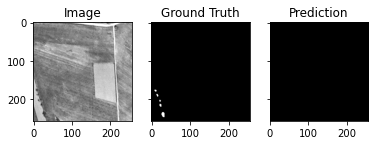

<Figure size 432x288 with 0 Axes>

Saving patch_4_id_2385.png


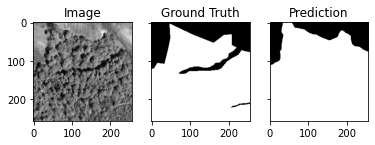

<Figure size 432x288 with 0 Axes>

Saving patch_5_id_1615.png


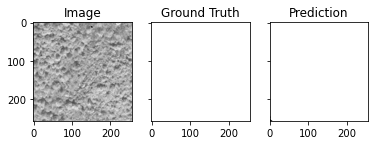

<Figure size 432x288 with 0 Axes>

Saving patch_6_id_364.png


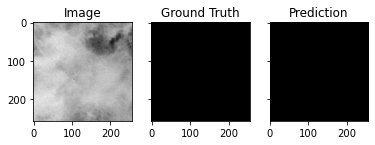

<Figure size 432x288 with 0 Axes>

Saving patch_7_id_120.png


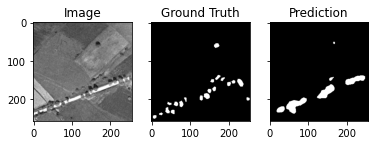

<Figure size 432x288 with 0 Axes>

Saving patch_8_id_97.png


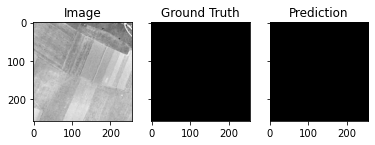

<Figure size 432x288 with 0 Axes>

Saving patch_9_id_2977.png


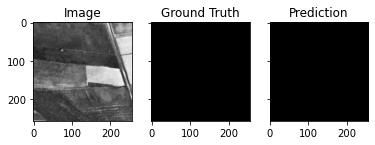

<Figure size 432x288 with 0 Axes>

Saving patch_10_id_1444.png


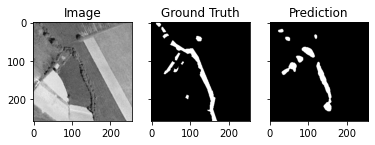

<Figure size 432x288 with 0 Axes>

Saving patch_11_id_1958.png


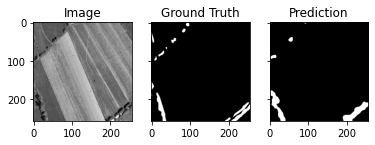

<Figure size 432x288 with 0 Axes>

Saving patch_12_id_1861.png


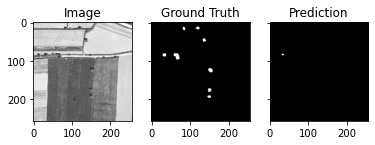

<Figure size 432x288 with 0 Axes>

Saving patch_13_id_3091.png


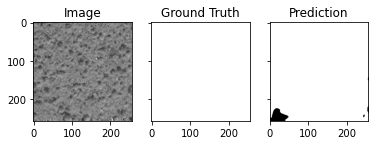

<Figure size 432x288 with 0 Axes>

Saving patch_14_id_434.png


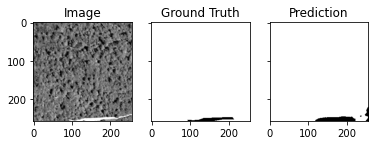

<Figure size 432x288 with 0 Axes>

Saving patch_15_id_562.png


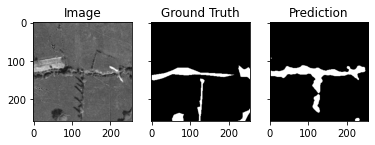

<Figure size 432x288 with 0 Axes>

Saving patch_16_id_2423.png


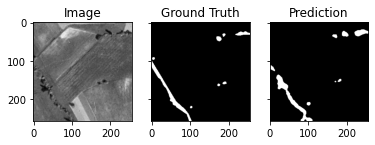

<Figure size 432x288 with 0 Axes>

Saving patch_17_id_1448.png


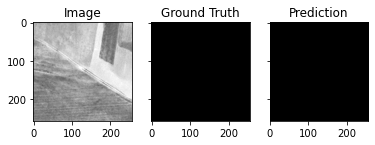

<Figure size 432x288 with 0 Axes>

Saving patch_18_id_2655.png


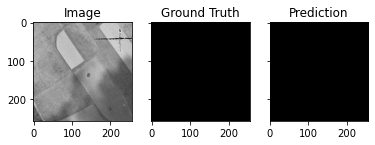

<Figure size 432x288 with 0 Axes>

Saving patch_19_id_57.png


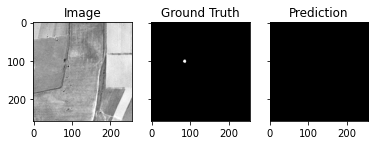

<Figure size 432x288 with 0 Axes>

Saving patch_20_id_2374.png


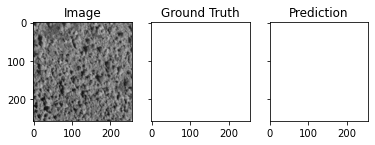

<Figure size 432x288 with 0 Axes>

Saving patch_21_id_497.png


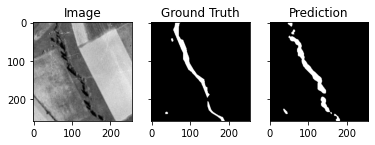

<Figure size 432x288 with 0 Axes>

Saving patch_22_id_1650.png


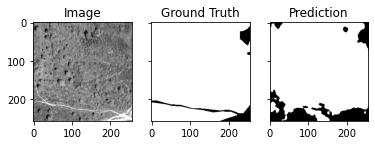

<Figure size 432x288 with 0 Axes>

Saving patch_23_id_2706.png


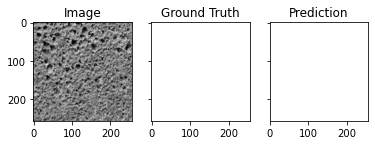

<Figure size 432x288 with 0 Axes>

Saving patch_24_id_3390.png


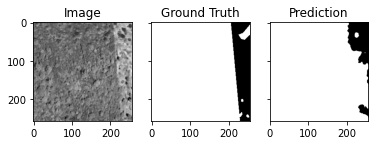

<Figure size 432x288 with 0 Axes>

Saving patch_25_id_2565.png


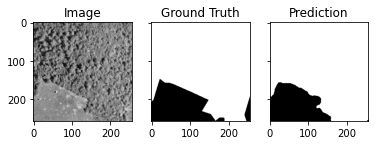

<Figure size 432x288 with 0 Axes>

Saving patch_26_id_604.png


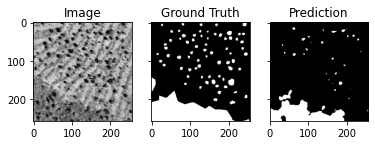

<Figure size 432x288 with 0 Axes>

Saving patch_27_id_763.png


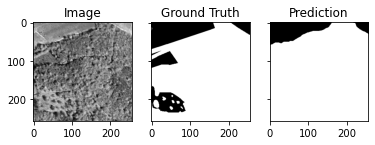

<Figure size 432x288 with 0 Axes>

Saving patch_28_id_835.png


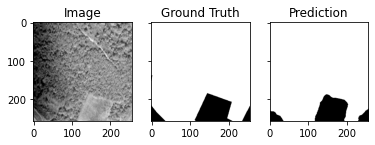

<Figure size 432x288 with 0 Axes>

Saving patch_29_id_205.png


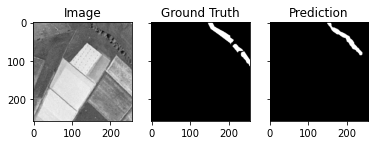

<Figure size 432x288 with 0 Axes>

Saving patch_30_id_1878.png


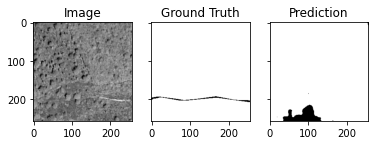

<Figure size 432x288 with 0 Axes>

Saving patch_31_id_2705.png


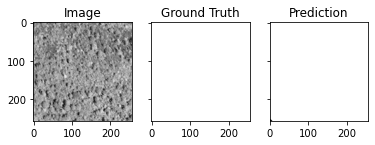

<Figure size 432x288 with 0 Axes>

Saving patch_32_id_566.png


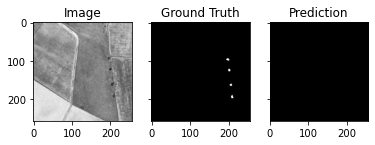

<Figure size 432x288 with 0 Axes>

Saving patch_33_id_1812.png


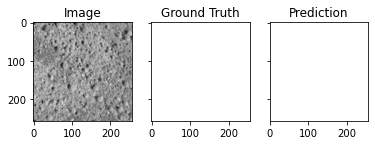

<Figure size 432x288 with 0 Axes>

Saving patch_34_id_635.png


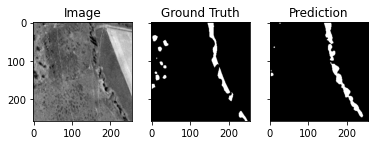

<Figure size 432x288 with 0 Axes>

Saving patch_35_id_1644.png


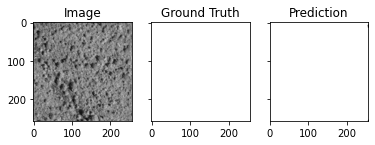

<Figure size 432x288 with 0 Axes>

Saving patch_36_id_632.png


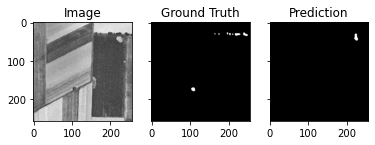

<Figure size 432x288 with 0 Axes>

Saving patch_37_id_2737.png


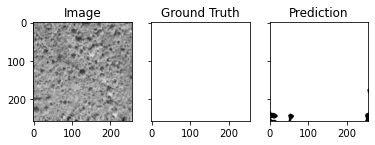

<Figure size 432x288 with 0 Axes>

Saving patch_38_id_435.png


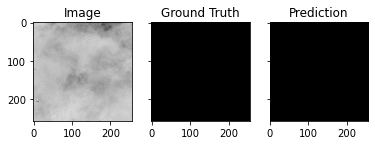

<Figure size 432x288 with 0 Axes>

Saving patch_39_id_119.png


In [12]:
# set the model in evaluation model
BEST_MODEL = '../best_model'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
print(best_iou_model)
folder = '../saved_images'

model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=True, save_patches=True)

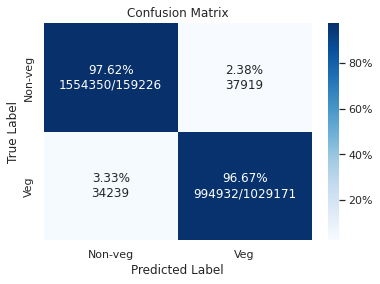

              precision    recall  f1-score   support

     Non-veg       0.98      0.98      0.98   1592269
         Veg       0.96      0.97      0.97   1029171

    accuracy                           0.97   2621440
   macro avg       0.97      0.97      0.97   2621440
weighted avg       0.97      0.97      0.97   2621440

IoU 0.9323787


In [13]:
labels = [0,1]
target_names = ['Non-veg', 'Veg']
metrics.cm_analysis(y_true, y_hat, labels, target_names)

In [14]:
# rates = [0.1, 0.25, 0.5, 0.75, 1.]

# # set the model in evaluation model
# BEST_MODEL = '../best_model/coarse_sizes'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model.sort()
# folder = '../saved_images'

# iou_all = {}
# for i, rate in zip(best_iou_model, rates):
#     # load the model 
#     model_ = model.unet_model.to(config.DEVICE)
#     model_.load_state_dict(torch.load(i))
    
#     # get the y_hat and y_true
#     y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test,folder, print_pred=False, save_patches=False)
    
#     # get IoU
#     all_metrics = metrics.metrics(y_hat, y_true)
#     iou = all_metrics['iou']
    
#     # save dict
#     # iou_all.append(iou)
#     iou_all.update([(rate,iou)])
    
# plt.plot(iou_all.keys(),  iou_all.values())
# plt.plot([0., 1.], [0.91, 0.91], "k--", color= 'r')
# plt.xlabel('% of COARSE DATASET')
# plt.ylabel('IOU')
# plt.title(f'COARSE DATASET')
# plt.show()

In [15]:
# # WandB – Initialize a new run
# # wandb.init(entity="vibferreira", project="master_thesis")

# # set the model in evaluation model
# data_portion= 'coarse_labels'
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][0]
# print(best_iou_model)
# folder = '../saved_images'

# # load the model 
# model_ = model.unet_model.to(config.DEVICE)
# model_.load_state_dict(torch.load(best_iou_model))

# y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder)

In [16]:
# # set the model in evaluation model
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model.sort()
# portions = ['coarse_plus_fine_labels', 'coarse_labels', 'fine_labels']
# portions.sort()
# folder = '../saved_images'

# for i, p in zip(best_iou_model, portions):
#     # load the model 
#     model_ = model.unet_model.to(config.DEVICE)
#     model_.load_state_dict(torch.load(i))
    
#     y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False)
#     y_hat, y_true, y_score = y_hat.detach().cpu().numpy(), y_true.detach().cpu().numpy(), y_score.detach().cpu().numpy()
    
#     fpr, tpr, thresholds = roc_curve(y_true, y_score)
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.15)
#     plt.plot(fpr, tpr, lw=lw, label=f'{p} (area = {roc_auc: 0.4f})')

#     plt.xlabel('Specificity - False Positive Rate')
#     plt.ylabel('Sensitivity - True Positive Rate')
#     plt.title(f'ROC')
#     plt.legend(loc="lower right")